In [ ]:
#!pip install cdsapi xarray netCDF4 numpy pandas matplotlib cartopy pillow
#!pip install --upgrade cdsapi

# Import Pachages

In [5]:
import geopandas as gpd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import numpy as np
from shapely.geometry import Point
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cdsapi

# Connect Data Source

In [6]:
c = cdsapi.Client()
print("CDS API is working!")

2025-09-18 00:30:44,469 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-18 00:30:44,470 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


CDS API is working!


## Fetch Data

In [7]:
import cdsapi

dataset = "reanalysis-era5-single-levels"

request = {
    "product_type": "reanalysis",
    "variable": ["10m_u_component_of_wind", "10m_v_component_of_wind"],
    "year": "2025",
    "month": "08",
    "day": [
        "25", "26", "27", "28", "29", "30"
    ],
    "time": [f"{h:02d}:00" for h in range(0, 24, 3)],
    "format": "netcdf",
    "area": [37.5, 68.7, 6.7, 97.25]
}

client = cdsapi.Client()

output_file = "I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Data\wind_25to30Aug2025.nc"

client.retrieve(dataset, request, output_file)

print(f"Data successfully downloaded to {output_file}")

<>:20: SyntaxWarning: invalid escape sequence '\P'
<>:20: SyntaxWarning: invalid escape sequence '\P'
C:\Users\User\AppData\Local\Temp\ipykernel_1416\2972508895.py:20: SyntaxWarning: invalid escape sequence '\P'
  output_file = "I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Data\wind_25to30Aug2025.nc"
2025-09-18 00:32:21,621 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-18 00:32:21,622 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-18 00:32:23,056 INFO Request ID is 0581f482-70f8-4dfc-9cfa-203551dbe5e2
2025-09-18 00:32:23,381 INFO status has been updated to accepted
2025-09-18 00:32:38,501 INFO status has been updated to running
2025-09-18 00:32:46,400 INFO status has been updated to successful


694a6da640e127e907811233e9f7a43a.nc:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Data successfully downloaded to I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Data\wind_25to30Aug2025.nc


## Read AOI

In [8]:
bd = gpd.read_file("Data\Administrative areas (GADM) BD\BGD_adm0.shp")
bd = bd.to_crs(epsg=4326)

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\User\AppData\Local\Temp\ipykernel_1416\436697015.py:1: SyntaxWarning: invalid escape sequence '\A'
  bd = gpd.read_file("Data\Administrative areas (GADM) BD\BGD_adm0.shp")


## Select data and work on it

In [9]:
ds = xr.open_dataset("I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Data\wind_25to30Aug2025.nc")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\User\AppData\Local\Temp\ipykernel_1416\2152805578.py:1: SyntaxWarning: invalid escape sequence '\P'
  ds = xr.open_dataset("I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Data\wind_25to30Aug2025.nc")


In [11]:
u = ds['u10']
v = ds['v10']
lons = ds.longitude.values
lats = ds.latitude.values
times = ds.valid_time.values

lon2d, lat2d = np.meshgrid(lons, lats)
points = np.array([lon2d.flatten(), lat2d.flatten()]).T
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in points], crs="EPSG:4326")

inside = points_gdf.within(bd.unary_union)
mask = inside.values.reshape(lat2d.shape)

C:\Users\User\AppData\Local\Temp\ipykernel_1416\3917738559.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  inside = points_gdf.within(bd.unary_union)


# Plot Data (Visualization) & Animate

✅ Wind streamline animation saved as GIF.


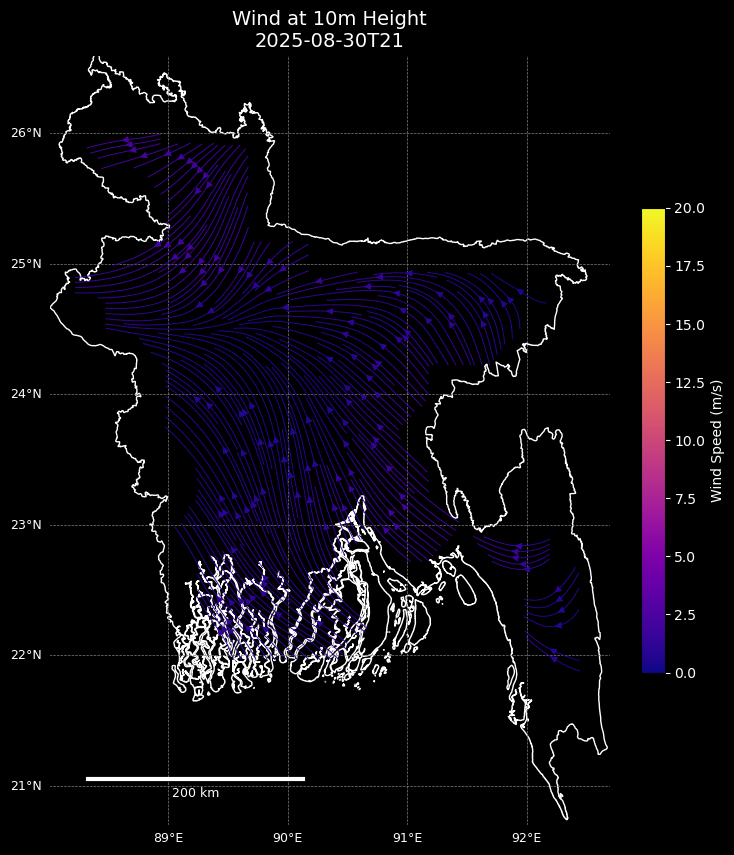

In [21]:
# --------------------------
# Map and figure setup
# --------------------------
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    facecolor='black'
)

# Set map extent for Bangladesh
ax.set_facecolor('black')
ax.set_extent([88.0, 92.7, 20.7, 26.6], crs=ccrs.PlateCarree())

# Plot Bangladesh boundary
bd.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

# --------------------------
# Colorbar setup
# --------------------------
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=0, vmax=20)  # Adjust vmax according to wind speed range

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Wind Speed (m/s)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# --------------------------
# Scale bar function
# --------------------------
def add_scalebar(ax, length_km=200, location=(0.05, 0.05), linewidth=3, text_color='white'):
    extent = ax.get_extent(ccrs.PlateCarree())
    lon_start = extent[0]
    lat_start = extent[2]
    lon_end = extent[1]
    lat_end = extent[3]

    km_per_deg = 111  # Approximate conversion
    length_deg = length_km / km_per_deg

    # Bar position
    bar_lon = lon_start + (lon_end - lon_start) * location[0]
    bar_lat = lat_start + (lat_end - lat_start) * location[1]

    # Draw the scale bar
    ax.plot(
        [bar_lon, bar_lon + length_deg], [bar_lat, bar_lat],
        transform=ccrs.PlateCarree(),
        color=text_color, linewidth=linewidth
    )

    # Place text slightly below the bar dynamically
    lat_offset = (lat_end - lat_start) * 0.01  # 1% of map height
    ax.text(
        bar_lon + length_deg / 2, bar_lat - lat_offset,
        f"{length_km} km",
        transform=ccrs.PlateCarree(),
        ha='center', va='top',
        color=text_color, fontsize=9
    )

# --------------------------
# Animation function
# --------------------------
def animate(i):
    ax.clear()
    ax.set_facecolor('black')
    ax.set_extent([88.0, 92.7, 20.7, 26.6], crs=ccrs.PlateCarree())

    # Bangladesh boundary
    bd.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'color': 'white', 'fontsize': 9}
    gl.ylabel_style = {'color': 'white', 'fontsize': 9}

    # Wind data (replace u, v, mask, lon2d, lat2d, times with your arrays)
    u_data = u[i].values
    v_data = v[i].values
    u_masked = np.where(mask, u_data, np.nan)
    v_masked = np.where(mask, v_data, np.nan)
    wind_speed = np.sqrt(u_masked**2 + v_masked**2)

    ax.streamplot(
        lon2d, lat2d,
        u_masked, v_masked,
        transform=ccrs.PlateCarree(),
        color=wind_speed,
        cmap=cmap,
        norm=norm,
        linewidth=0.7,
        density=5
    )

    # Title
    ax.set_title(
        f"Wind at 10m Height\n{np.datetime_as_string(times[i], unit='h')}",
        fontsize=14,
        color='white'
    )

    # Add scale bar
    add_scalebar(ax, length_km=200, location=(0.07, 0.06), text_color='white')

# --------------------------
# Create animation
# --------------------------
anim = animation.FuncAnimation(fig, animate, frames=len(times), interval=500)

# Save GIF
output_path = r"I:\Planning\Geospatial Python\geopy environment\Practices\Wind Data Visualization\Bangladesh_Wind_Streamlines.gif"
anim.save(output_path, writer="pillow", dpi=900)

print("✅ Wind streamline animation saved as GIF.")
plt.show()